# Install Dependecies

In [1]:
import os

In [2]:
try:
    from google.colab import drive
    IN_COLAB = True
    drive.mount('/content/drive')

    exp_repo='https://github.com/MArpogaus/Bernstein-Experiments.git'
    %cd "/content/drive/MyDrive/probabilistic_power_forecast"
    if os.path.exists('./exp'):
      %cd exp
      !git pull origin dev
    else:
      !git clone $exp_repo exp
      !git checkout dev
      %cd ./exp 
    !ls -la

    !pip install -Ue .

    !pip install -U git+https://github.com/MArpogaus/tensorflow-experiments@dev
    !pip install -U git+https://github.com/MArpogaus/TensorFlow-Probability-Bernstein-Polynomial-Bijector.git@fix-inverse
except:
    IN_COLAB = False
    if not os.path.exists('./ipynb'):
        %cd ..
    print('Not running in Colab')

/mnt/data/marcel/exp/plf/Bernstein-Experiments
Not running in Colab


# Import libraries

In [3]:
from datetime import datetime

In [4]:
import pandas as pd
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='ticks', context='paper')

In [5]:
from matplotlib.patches import ConnectionPatch

In [6]:
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow_probability import distributions as tfd
from tensorflow_probability import bijectors as tfb

In [7]:
tf.__version__

'2.4.1'

In [8]:
tfp.__version__

'0.12.1'

In [9]:
from pprint import pprint
from functools import partial

In [10]:
import tfexp

In [11]:
from bernstein_flow.distributions import BernsteinFlow
#from bernstein_paper.distributions.bernstein_flow_old import BernsteinFlow as BernsteinFlowOld

In [12]:
from bernstein_flow.util.visualization import plot_flow

In [13]:
from bernstein_paper.distributions import MixedNormal
from bernstein_paper.distributions import NormalDistribution
from bernstein_paper.distributions import QuantileRegressionDistributionWrapper
from bernstein_paper.losses import PinballLoss
from bernstein_paper.losses import NegativeLogarithmicLikelihood
from bernstein_paper.metrics import MeanAbsoluteError, MeanSquaredError, ContinuousRankedProbabilityScore

# Define Paths

In [14]:
cfg_path='./configs'

# Function Definitions

In [15]:
def file_list(path, ending=''):
    if os.path.exists(path):
        return [
            os.path.join(path, file)
            for file in os.listdir(path)
            if file.endswith(ending)
            and os.path.getsize(os.path.join(path, file)) > 0]
    else:
        return []

In [16]:
def probabilistic_model_stats(probabilistic_model, pvector):
    if len(pvector) != 1:
        dfs=[]
        for i in range(len(pvector)):
            dfs.append(probabilistic_model_stats(probabilistic_model, pvector[i][None,...]))
        return pd.concat(dfs,ignore_index=True)
    else:
        dist = probabilistic_model(pvector)

        mu = np.squeeze(dist.mean())

        try:
            q05 = np.squeeze(dist.quantile(.05))
            q1 = np.squeeze(dist.quantile(.1))
            q2 = np.squeeze(dist.quantile(.2))
            q8 = np.squeeze(dist.quantile(.8))
            q9 = np.squeeze(dist.quantile(.9))
            q95 = np.squeeze(dist.quantile(.95))
        except Exception as ex:
            print(ex)
            q05 = None
            q1 = None
            q2 = None
            q8 = None
            q9 = None
            q95 = None

        df = pd.DataFrame(dict(
            mu=mu,
            q05=q05,
            q1=q1,
            q2=q2,
            q8=q8,
            q9=q9,
            q95=q95
        ))

        return df

In [17]:
def plot_probabilistic_forecast(
    parameter_model,
    probabilistic_model,
    x,
    ax=plt):

    pvector = parameter_model(x)
    dist = probabilistic_model(pvector)
    df = probabilistic_model_stats(probabilistic_model, pvector)

    t=np.arange(len(df.mu))
        
    ax.plot(
        t,
        df.mu,
        label='$\mu$',
        c="black"
    )

    
    if probabilistic_model != MixedNormal:
        ax.plot(t, df.q95,
                   label='$q(95%)$',
                   c="skyblue")
        ax.plot(t, df.q8,
                   label='$q(80%)$',
                   c="skyblue")
        ax.plot(t, df.q2,
                   label='$q(20%)$',
                   c="skyblue")
        ax.plot(t, df.q05,
                   label='$q(5%)$',
                   c="skyblue")

        ax.fill_between(
            t,
            df.q95,
            df.q05,
            alpha=0.2,
            label='$Q(90%)$',
            fc='skyblue'
        )

        ax.fill_between(
            t,
            df.q8,
            df.q2,
            alpha=0.5,
            label='$Q(60%)$',
            fc='skyblue'
        )

    ax.legend(loc='upper left')
    
    return df

In [18]:
def plot_dist(dist, y, ax=plt, color='skyblue'):

    dense_y = dist.prob(y).numpy()

    ax.fill_between(
        np.squeeze(y),
        np.squeeze(dense_y),
        np.min(dense_y),
        fc=color,
        alpha=0.8
    )

    ax.plot(
        y,
        dense_y,
        '-',
        color='white',
        linewidth=2
    )

In [19]:
def stacked_dist_plot(
        parameter_model,
        probabilistic_model,
        x,
        y,
        hspace=-.5,
        title=None
    ):
    yy = np.linspace(0-.5*np.abs(y.min()), y.max(), 200).astype(np.float32)
    yy = yy[...,tf.newaxis]
    horizon_size = y.shape[1]
    y=y.flatten()

    pv = parameter_model(x)
    dists = [
        probabilistic_model(pv[:,d]) for d in range(horizon_size)
    ]

    pal1 = sns.cubehelix_palette(horizon_size/2, rot=.55, light=.8, reverse=True).as_hex()
    pal2 = sns.cubehelix_palette(horizon_size/2, rot=.55, light=.8).as_hex()
    pal = pal1 + pal2

    fig , ax = plt.subplots(horizon_size,figsize=(16,horizon_size*0.4), sharex=True, sharey=True)

    if title is not None:
        fig.suptitle(title, fontsize=24)

    yaxis = ConnectionPatch(
        xyA=(0,0),
        xyB=(0,10),
        coordsA='data',
        coordsB='data',
        axesA=ax[-1],
        axesB=ax[0],
        color='black',
        lw=1.5,
        arrowstyle='->'
        #arrowstyle='Fancy, head_length=0.4, head_width=0.1, tail_width=0.3'
    )
    ax[0].add_artist(yaxis)
        
    for i in range(horizon_size):
        if i >= 1:
            con = ConnectionPatch(
                xyA=(y[i-1],0),
                xyB=(y[i],0),
                coordsA='data',
                coordsB='data',
                axesA=ax[i-1],
                axesB=ax[i],
                color=pal[i],
                lw=2+1*i/horizon_size,
                alpha=0.8
            )
            ax[i].add_artist(con)
        plot_dist(dists[i],yy,ax=ax[i],color=pal[i])
        ax[i].plot(
            y[i],
            0,
            '.',
            color=pal[i],
            markersize=8+8*i/horizon_size)

        ax[i].set_facecolor((0,0,0,0))
        ax[i].set_frame_on(False)
        ax[i].set_title('')
        ax[i].axis('off')

        ax[i].text(0, 0.1, i, fontweight="bold", fontsize='xx-large', color=pal[i],
                   ha="left", va="center", transform=ax[i].transAxes)

    fig.subplots_adjust(hspace=hspace)

    return fig, ax

In [20]:
def plot_chained_bijectors(flow):
    chained_bijectors = flow.bijector.bijector.bijectors
    base_dist = flow.distribution
    cols = len(chained_bijectors) +1
    fig, ax = plt.subplots(1,cols,figsize=(4*cols,4))
    
    n=200

    z_samples = np.linspace(-3,3,n).astype(np.float32)
    log_probs = base_dist.log_prob(z_samples)

    ax[0].plot(z_samples, np.exp(log_probs))

    zz = z_samples[...,None]
    ildj = 0.
    for i,(a,b) in enumerate(zip(ax[1:],chained_bijectors)):
        z = b.inverse(zz) # we need to use the inverse here since we are going from z->y!
        ildj += b.forward_log_det_jacobian(z,1)
        #print(z.shape, zz.shape, ildj.shape)
        a.plot(z, np.exp(log_probs + ildj))
        a.set_title(b.name.replace('_', ' '))
        a.set_xlabel(f'$z_{i}$')
        a.set_ylabel(f'$p(z_{i+1})$')
        zz = z
    fig.tight_layout()

In [21]:
def plot_save_plf(model_names,x,y,figsize=(16,8),postfix=None,concat_df=None):
    for a,m in zip(ax,model_names):
        fig = plt.figure(figsize=figsize)
        df=plot_probabilistic_forecast(
            models[m],
            prob_models[m],
            x=x)
        plt.plot(y.flatten(),color='orange',label='load')
        fig.suptitle(m.replace('_',' ').title())

        if postfix is not None:
            file_name=m + postfix + '.csv'
            file_path=os.path.join(csv_path,file_name)
            df['y']=y.flatten()
            if concat_df is not None:
                df = pd.concat([df,concat_df],axis='columns')
            df.index.name = 't'
            df.to_csv(file_path)

In [22]:
def flot_save_ridge_plots(model_names,x,y,postfix=None):
    for m in model_names:
        fig = stacked_dist_plot(models[m], prob_models[m], x, y)
        if postfix is not None:
            file_name=m + postfix + '.pgf'
            file_path=os.path.join(tikz_path,file_name)
            fig.savefig(file_path, bbox_inches='tight', transparent=True)

In [23]:
def score_observation(dist,y,ci=.90,tol=4):
    yl=(1-ci)/2
    yh=1-yl
    pv = param_model(x)
    dist = prob_model(pv)
    ql = np.reshape([
        m.bijector.forward(
            m.distribution.quantile(yl)
        ) for m in dist.distributions.model
    ],(1,48))
    qh = np.reshape([
        m.bijector.forward(
            m.distribution.quantile(yh)
        ) for m in dist.distributions.model
    ],(1,48))
    score = ((y<ql) | (y>qh)).sum(axis=1)
    return score <= tol

In [24]:
def anomalie_plot(prob_model, param_model,x,y,ci=.90,tol=4):
    pv = param_model(x)
    dist = prob_model(pv)
    score = score_observation(dist, y, ci=ci, tol=tol)

    c=['green' if ok else 'red' for ok in score]
    a=[.5 if ok else .05 for ok in score]


    fig = plt.figure(figsize=(16,8))
    for i in range(y.shape[0]):
        plt.plot(
            y[i],
            c=c[i],
            alpha=a[i]
        )
    plot_probabilistic_forecast(param_model, prob_model,x=x)

In [25]:
def patch_to_csv(x,y,file_name):
    df=pd.DataFrame(x.reshape(-1,3).copy(),columns=columns)
    df['y']=[np.nan]*(len(x)-48) + np.squeeze(y).tolist()
    df['load'][-48:] = np.nan
    df.plot(figsize=(16,8))
    df.index.name='t'
    df.to_csv(os.path.join(csv_path, file_name))

# Files

In [26]:
cfg_files=file_list(cfg_path,'yaml')
cfg_files

['./configs/feed_forward_bernstein_flow.yaml',
 './configs/feed_forward_gmm.yaml',
 './configs/feed_forward_normal_distribution.yaml',
 './configs/feed_forward_quantile_regression.yaml',
 './configs/wavenet_bernstein_flow.yaml',
 './configs/wavenet_gmm.yaml',
 './configs/wavenet_normal_distribution.yaml',
 './configs/wavenet_quantile_regression.yaml']

In [27]:
cfgs = {c.name: c for c in list(map(tfexp.configuration.Configuration.from_yaml, cfg_files))}
cfgs

{'feed_forward_bernstein_flow': Configuration(
   compile_kwds={   'loss': <bernstein_paper.losses.negative_logarithmic_likelihood.NegativeLogarithmicLikelihood object at 0x7ff3c0fb1070>,
     'optimizer': 'adam'},
   data_loader_kwds={   'batch_size': 128,
     'cycle_length': 10,
     'data_path': '../paper_data/mini',
     'history_columns': ['load'],
     'history_size': 672,
     'meta_columns': ['dayofyear_sin', 'dayofyear_cos', 'weekday', 'is_holiday'],
     'prediction_columns': ['load'],
     'prediction_size': 48,
     'seed': 42,
     'shift': 48,
     'shuffle_buffer_size': 100,
     'validation_split': 0.1},
   data_preprocessor=None,
   evaluate_kwds={},
   fit_kwds={   'callbacks': [   <tensorflow.python.keras.callbacks.ModelCheckpoint object at 0x7ff3bc6f4cd0>,
     'epochs': 300,
     'validation_freq': 1},
   model_checkpoints='./logs/feed_forward_bernstein_flow/mcp',
   name='feed_forward_bernstein_flow',
   seed=42
 ),
 'feed_forward_gmm': Configuration(
   compile_

# Load Models (Checkpoint)

In [28]:
models = {cfg.name: tfexp.build_model(cfg) for cfg in cfgs.values()}

restoring model from checkpoint ./logs/feed_forward_bernstein_flow/mcp/20210318-175401
restoring model from checkpoint ./logs/feed_forward_gmm/mcp/20210318-181145
restoring model from checkpoint ./logs/feed_forward_normal_distribution/mcp/20210318-184124
restoring model from checkpoint ./logs/feed_forward_qunatile_regression/mcp/20210318-192139
restoring model from checkpoint ./logs/wavenet_bernstein_flow/mcp/20210318-165340


In [29]:
for m in models.values():
    m.summary()

Model: "feed_forward_bernstein_flow"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 672, 1)]     0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 1, 9)]       0                                            
__________________________________________________________________________________________________
flatten (Flatten)               (None, 672)          0           input_1[0][0]                    
__________________________________________________________________________________________________
flatten_1 (Flatten)             (None, 9)            0           input_2[0][0]                    
________________________________________________________________________

# Plot History

In [30]:
read_csv = partial(pd.read_csv,index_col='epoch')

In [31]:
base_paths = {cfg.name: os.path.split(cfg.model_checkpoints)[0] for cfg in cfgs.values()}
base_paths

{'feed_forward_bernstein_flow': './logs/feed_forward_bernstein_flow',
 'feed_forward_gmm': './logs/feed_forward_gmm',
 'feed_forward_normal_distribution': './logs/feed_forward_normal_distribution',
 'feed_forward_qunatile_regression': './logs/feed_forward_qunatile_regression',
 'wavenet_bernstein_flow': './logs/wavenet_bernstein_flow',
 'wavenet_gmm': './logs/wavenet_gmm',
 'wavenet_normal_distribution': './logs/wavenet_normal_distribution',
 'wavenet_qunatile_regression': './logs/wavenet_qunatile_regression'}

In [32]:
hist_dfs = {
    k: pd.concat(
        (
            pd.read_csv(f)
            for f in sorted(file_list(v,'csv'))
        ),
        ignore_index=True
    )
    for k,v in base_paths.items() if len(file_list(v,'csv'))}

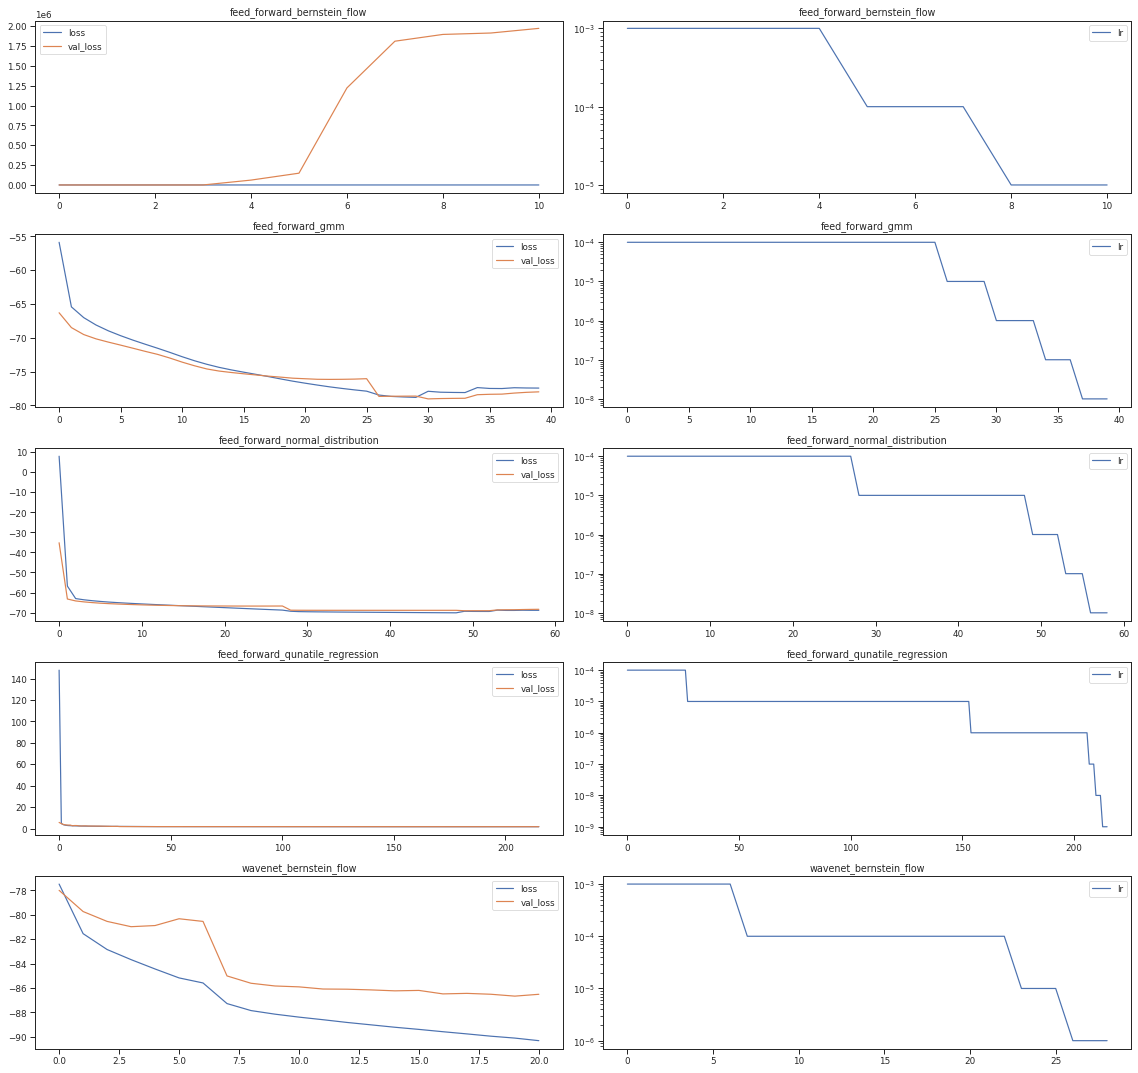

In [33]:
fig, ax = plt.subplots(len(hist_dfs),2, figsize=(16,3 * len(hist_dfs)))
if ax.size == 2:
    ax = ax[np.newaxis]
for i,(name,hist) in enumerate(hist_dfs.items()):
    hist[['loss','val_loss']].plot(title=name, ax=ax[i,0])
    hist[['lr']].plot(logy=True, title=name, ax=ax[i,1])
fig.tight_layout()

In [34]:
pd.DataFrame({name: hist.val_loss.describe() for name,hist in hist_dfs.items()})

,feed_forward_bernstein_flow,feed_forward_gmm,feed_forward_normal_distribution,feed_forward_qunatile_regression,wavenet_bernstein_flow
count,1.100000e+01,40.000000,59.000000,216.000000,21.000000
mean,8.211689e+05,-75.314121,-67.001925,1.901731,-84.129427
std,9.251202e+05,3.304503,4.475274,0.426660,2.968056
min,-7.591804e+01,-79.044830,-69.072594,1.755648,-86.666725
25%,-7.488350e+01,-78.345438,-68.868771,1.760068,-86.233650
50%,1.484549e+05,-76.017693,-68.410408,1.784297,-85.906975
75%,1.855063e+06,-73.450682,-66.545109,1.823425,-80.877525
max,1.974185e+06,-66.298462,-35.157219,5.726576,-77.990341


In [35]:
{name: hist.loss.min() for name,hist in hist_dfs.items()}

{'feed_forward_bernstein_flow': -82.09265899658203,
 'feed_forward_gmm': -78.8228759765625,
 'feed_forward_normal_distribution': -70.11735534667969,
 'feed_forward_qunatile_regression': 1.7040140628814695,
 'wavenet_bernstein_flow': -90.32086944580078}

In [36]:
{name: hist.val_loss.min() for name,hist in hist_dfs.items()}

{'feed_forward_bernstein_flow': -75.91803741455078,
 'feed_forward_gmm': -79.04483032226562,
 'feed_forward_normal_distribution': -69.07259368896484,
 'feed_forward_qunatile_regression': 1.7556483745574951,
 'wavenet_bernstein_flow': -86.6667251586914}

# Match Probabilistic Model

In [55]:
eval_models = [
    c for c in hist_dfs.keys()
]
eval_models

['feed_forward_bernstein_flow',
 'feed_forward_gmm',
 'feed_forward_normal_distribution',
 'feed_forward_qunatile_regression',
 'wavenet_bernstein_flow']

In [56]:
def match_prob_model(name):
    if 'flow' in name:
        if 'old' in name:
            return BernsteinFlowOld
        else:
            return BernsteinFlow
    elif 'gmm' in name:
        return MixedNormal
    elif 'qunatile_regression' in name:
        return QuantileRegressionDistributionWrapper
    elif 'normal_distribution' in name:
        return NormalDistribution

In [57]:
prob_models={
    m: match_prob_model(m)
    for m in eval_models}
prob_models

{'feed_forward_bernstein_flow': bernstein_flow.distributions.bernstein_flow.BernsteinFlow,
 'feed_forward_gmm': bernstein_paper.distributions.mixed_normal.MixedNormal,
 'feed_forward_normal_distribution': bernstein_paper.distributions.normal_distribution.NormalDistribution,
 'feed_forward_qunatile_regression': bernstein_paper.distributions.quantile_regression_distribution_wrapper.QuantileRegressionDistributionWrapper,
 'wavenet_bernstein_flow': bernstein_flow.distributions.bernstein_flow.BernsteinFlow}

In [58]:
models

{'feed_forward_bernstein_flow': <tensorflow.python.keras.engine.functional.Functional at 0x7ff3bc6130a0>,
 'feed_forward_gmm': <tensorflow.python.keras.engine.functional.Functional at 0x7ff3bc5d1820>,
 'feed_forward_normal_distribution': <tensorflow.python.keras.engine.functional.Functional at 0x7ff3bc58ebb0>,
 'feed_forward_qunatile_regression': <tensorflow.python.keras.engine.functional.Functional at 0x7ff3bc5aba00>,
 'wavenet_bernstein_flow': <tensorflow.python.keras.engine.functional.Functional at 0x7ff3bc50d0d0>,
 'wavenet_gmm': <tensorflow.python.keras.engine.functional.Functional at 0x7ff3bc4c63a0>,
 'wavenet_normal_distribution': <tensorflow.python.keras.engine.functional.Functional at 0x7ff3bc4a6eb0>,
 'wavenet_qunatile_regression': <tensorflow.python.keras.engine.functional.Functional at 0x7ff3bc4b76a0>}

In [59]:
prob_models

{'feed_forward_bernstein_flow': bernstein_flow.distributions.bernstein_flow.BernsteinFlow,
 'feed_forward_gmm': bernstein_paper.distributions.mixed_normal.MixedNormal,
 'feed_forward_normal_distribution': bernstein_paper.distributions.normal_distribution.NormalDistribution,
 'feed_forward_qunatile_regression': bernstein_paper.distributions.quantile_regression_distribution_wrapper.QuantileRegressionDistributionWrapper,
 'wavenet_bernstein_flow': bernstein_flow.distributions.bernstein_flow.BernsteinFlow}

# Load Data

In [60]:
from bernstein_paper.data.cer_data_loader import load_data

In [61]:
from bernstein_paper.data.dataset import WindowedTimeSeriesDataSet

In [62]:
cfg = cfgs[eval_models[0]]
cfg

Configuration(
  compile_kwds={   'loss': <bernstein_paper.losses.negative_logarithmic_likelihood.NegativeLogarithmicLikelihood object at 0x7ff3c0fb1070>,
    'optimizer': 'adam'},
  data_loader_kwds={   'batch_size': 128,
    'cycle_length': 10,
    'data_path': '../paper_data/mini',
    'history_columns': ['load'],
    'history_size': 672,
    'meta_columns': ['dayofyear_sin', 'dayofyear_cos', 'weekday', 'is_holiday'],
    'prediction_columns': ['load'],
    'prediction_size': 48,
    'seed': 42,
    'shift': 48,
    'shuffle_buffer_size': 100,
    'validation_split': 0.1},
  data_preprocessor=None,
  evaluate_kwds={},
  fit_kwds={   'callbacks': [   <tensorflow.python.keras.callbacks.ModelCheckpoint object at 0x7ff3bc6f4cd0>,
    'epochs': 300,
    'validation_freq': 1},
  model_checkpoints='./logs/feed_forward_bernstein_flow/mcp',
  name='feed_forward_bernstein_flow',
  seed=42
)

In [63]:
dl_kwds=cfg.data_loader_kwds.copy()
dl_kwds.pop('validation_split')

dl_kwds.update({'cycle_length': 1, 'shuffle_buffer_size': 0, 'batch_size': 7})
data_path=dl_kwds.pop('data_path')

dl_kwds

{'history_size': 672,
 'prediction_size': 48,
 'shift': 48,
 'history_columns': ['load'],
 'meta_columns': ['dayofyear_sin', 'dayofyear_cos', 'weekday', 'is_holiday'],
 'prediction_columns': ['load'],
 'batch_size': 7,
 'cycle_length': 1,
 'shuffle_buffer_size': 0,
 'seed': 42}

In [64]:
column_transformers = {}
column_transformers['load'] = lambda x: tf.sqrt(x / 14.134)
column_transformers['weekday'] = lambda x: tf.one_hot(
    tf.cast(tf.squeeze(x), tf.uint8), 6)
gen_ds=WindowedTimeSeriesDataSet(**dl_kwds, column_transformers=column_transformers)

In [65]:
data=pd.read_csv(
    os.path.join(data_path,'test.csv'),
    parse_dates=['date_time'],
    infer_datetime_format=True,
    index_col=['date_time'],
    dtype={'id': 'uint16',
           'load': 'float32',
           'is_holiday': 'uint8',
           'weekday': 'uint8'})

In [66]:
ds = gen_ds(data)

# Select Test Patch

In [67]:
first_week=data.loc[str(data.index.date.min()):str(data.index.date.min()+pd.offsets.Week(3)-pd.offsets.Minute(1))]
f'firts week ranges from {first_week.index.min()+pd.offsets.Week(1)} to {first_week.index.max()}'

'firts week ranges from 2010-11-08 00:00:00 to 2010-11-21 23:30:00'

In [68]:
first_week

,id,load,is_holiday,weekday,dayofyear_sin,dayofyear_cos
date_time,,,,,,
2010-11-01 00:00:00,1035,19.171,0,0,-0.858764,0.512371
2010-11-01 00:30:00,1035,15.843,0,0,-0.858764,0.512371
2010-11-01 01:00:00,1035,6.561,0,0,-0.858764,0.512371
2010-11-01 01:30:00,1035,5.640,0,0,-0.858764,0.512371
2010-11-01 02:00:00,1035,6.238,0,0,-0.858764,0.512371
...,...,...,...,...,...,...
2010-11-21 21:30:00,7436,0.364,0,6,-0.635432,0.772157
2010-11-21 22:00:00,7436,0.360,0,6,-0.635432,0.772157
2010-11-21 22:30:00,7436,0.376,0,6,-0.635432,0.772157


In [69]:
first_week_ds = gen_ds(first_week[first_week.id == 7436])

/mnt/data/marcel/exp/plf/Bernstein-Experiments/src/bernstein_paper/data/dataset/windowed_time_series_data_set.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[cycl_name + '_sin'] = np.float32(np.sin(2 * np.pi * cycl / cycl_max))
/mnt/data/marcel/exp/plf/Bernstein-Experiments/src/bernstein_paper/data/dataset/windowed_time_series_data_set.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[cycl_name + '_cos'] = np.float32(np.cos(2 * np.pi * cycl / cycl_max))


In [70]:
batch_iter = first_week_ds.as_numpy_iterator()

(test_x1, test_x2),test_y = next(batch_iter)

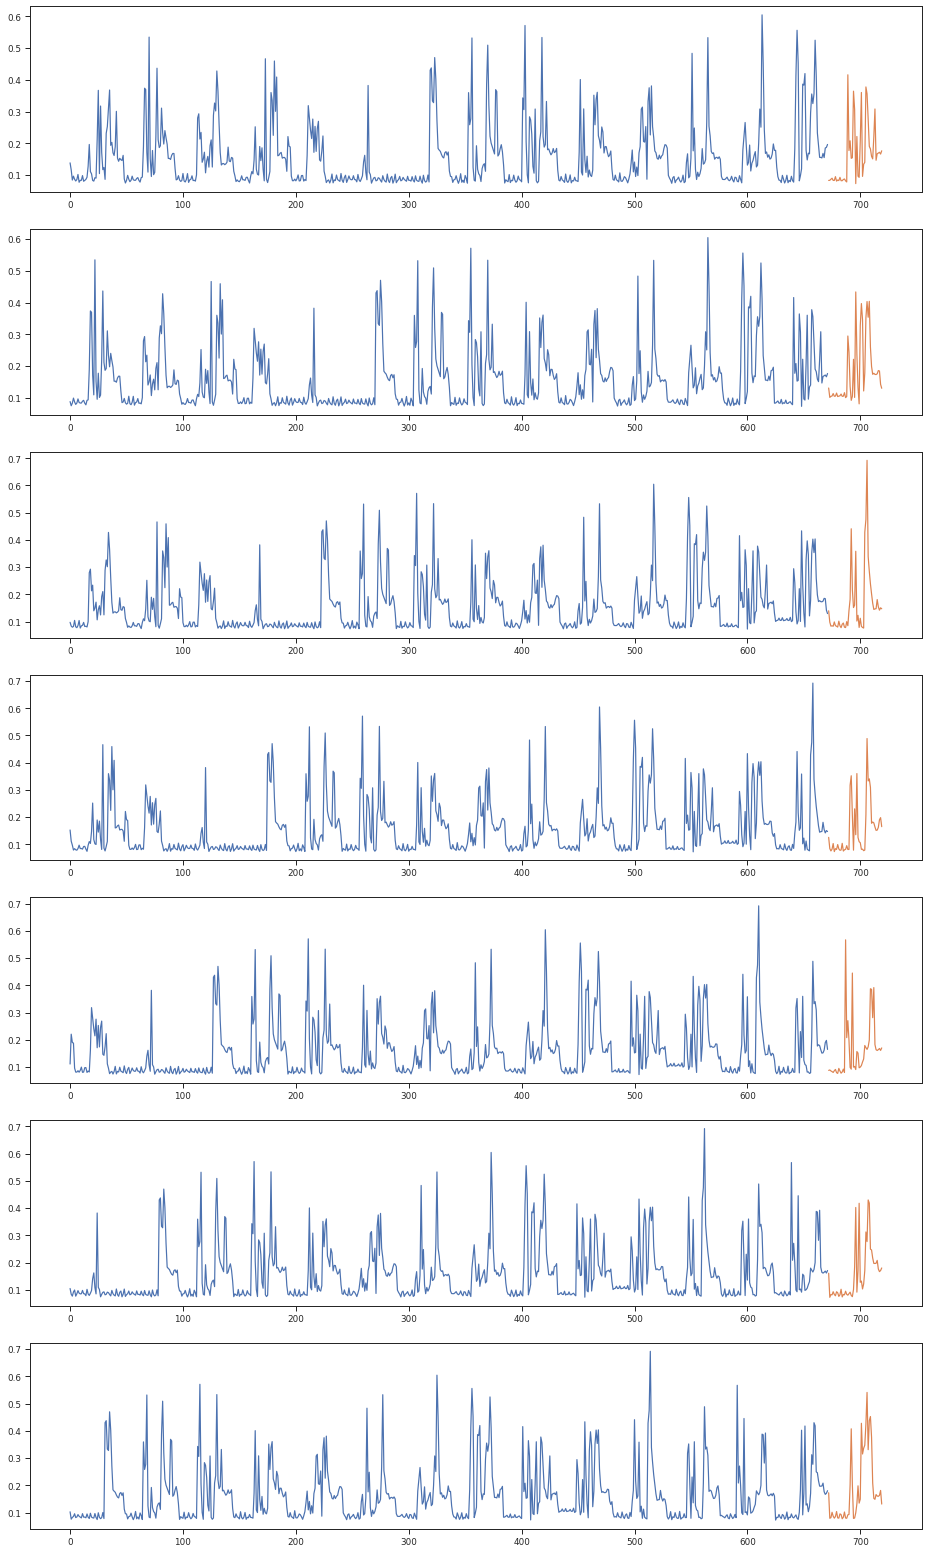

In [71]:
days=test_x1.shape[0]
fig, ax = plt.subplots(days, figsize=(16,4*days))
for i,(x,y) in enumerate(zip(test_x1, test_y)):
    x = x.flatten()
    y = y.flatten()
    ax[i].plot(np.arange(0,len(x)), x)
    ax[i].plot(np.arange(len(x),len(x)+len(y)), y)

# Plot Forecast

quantile is not implemented: MixedNormal


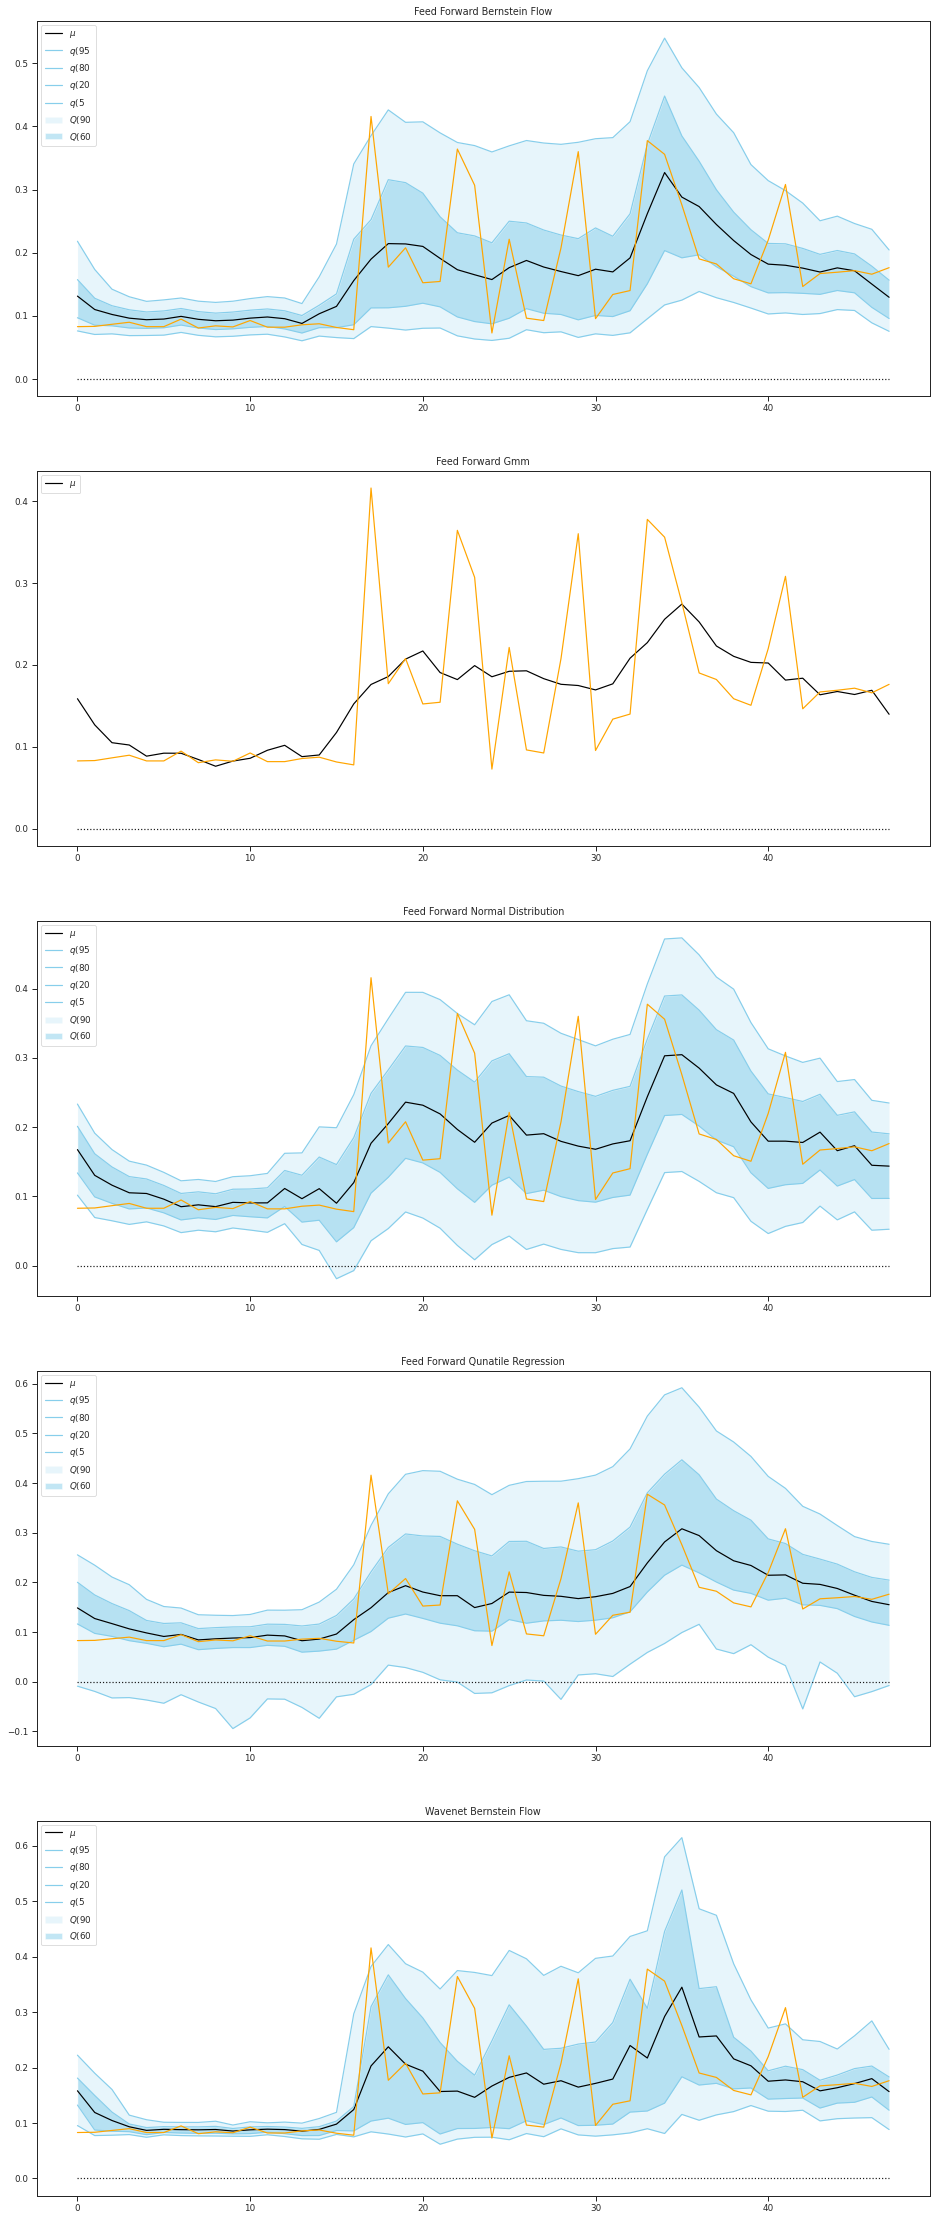

In [72]:
x=(test_x1[:1],test_x2[:1])
y=test_y[:1]

plots=len(eval_models)
fig, ax = plt.subplots(plots, figsize=(16,8*plots))

for i,m in enumerate(eval_models):
    
    if plots > 1:
        a = ax[i]
    else:
        a = ax
    df=plot_probabilistic_forecast(
        models[m],
        prob_models[m],
        x=x,
        ax=a
    )    
    a.plot(y.flatten(),color='orange',label='load')
    a.plot(np.zeros_like(y.flatten()),'k:')
    a.set_title(m.replace('_',' ').title())

# Stacked Density Plot

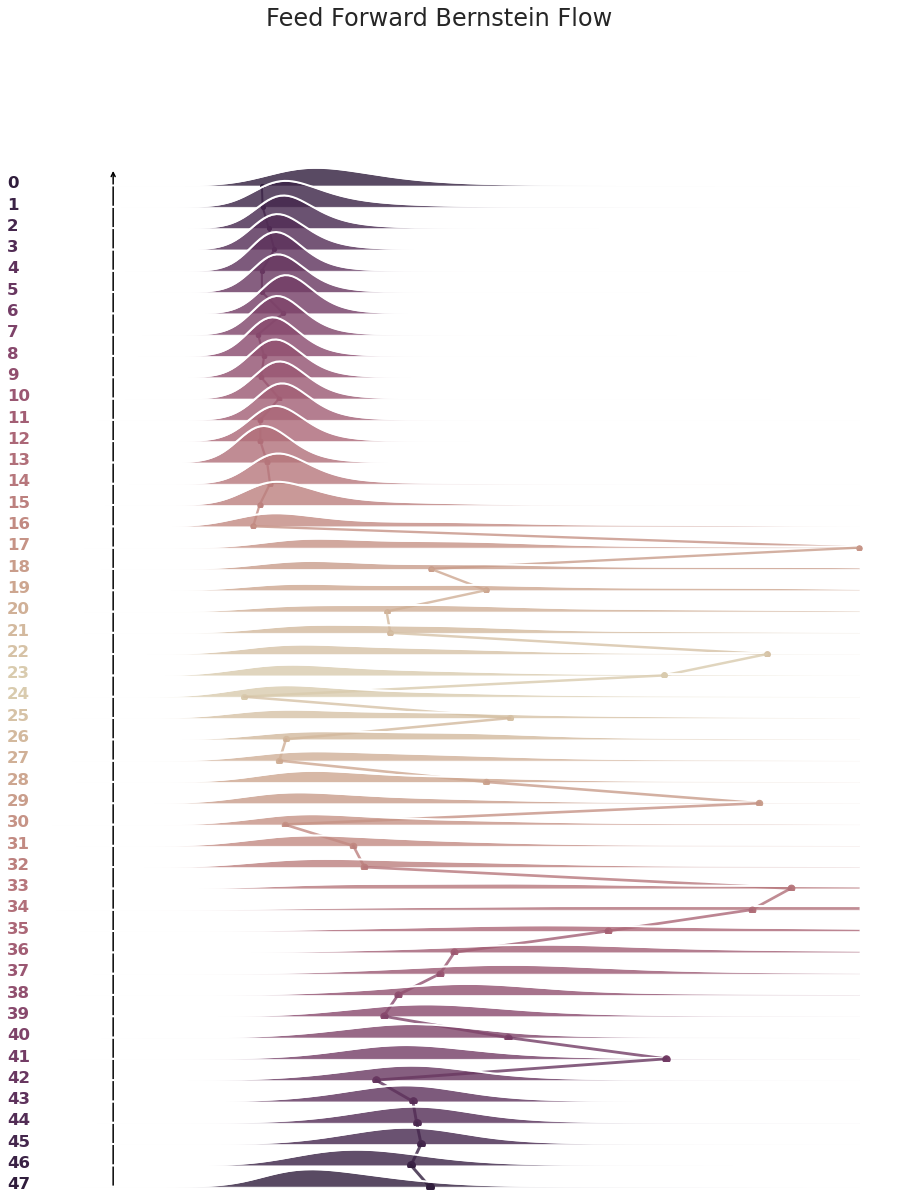

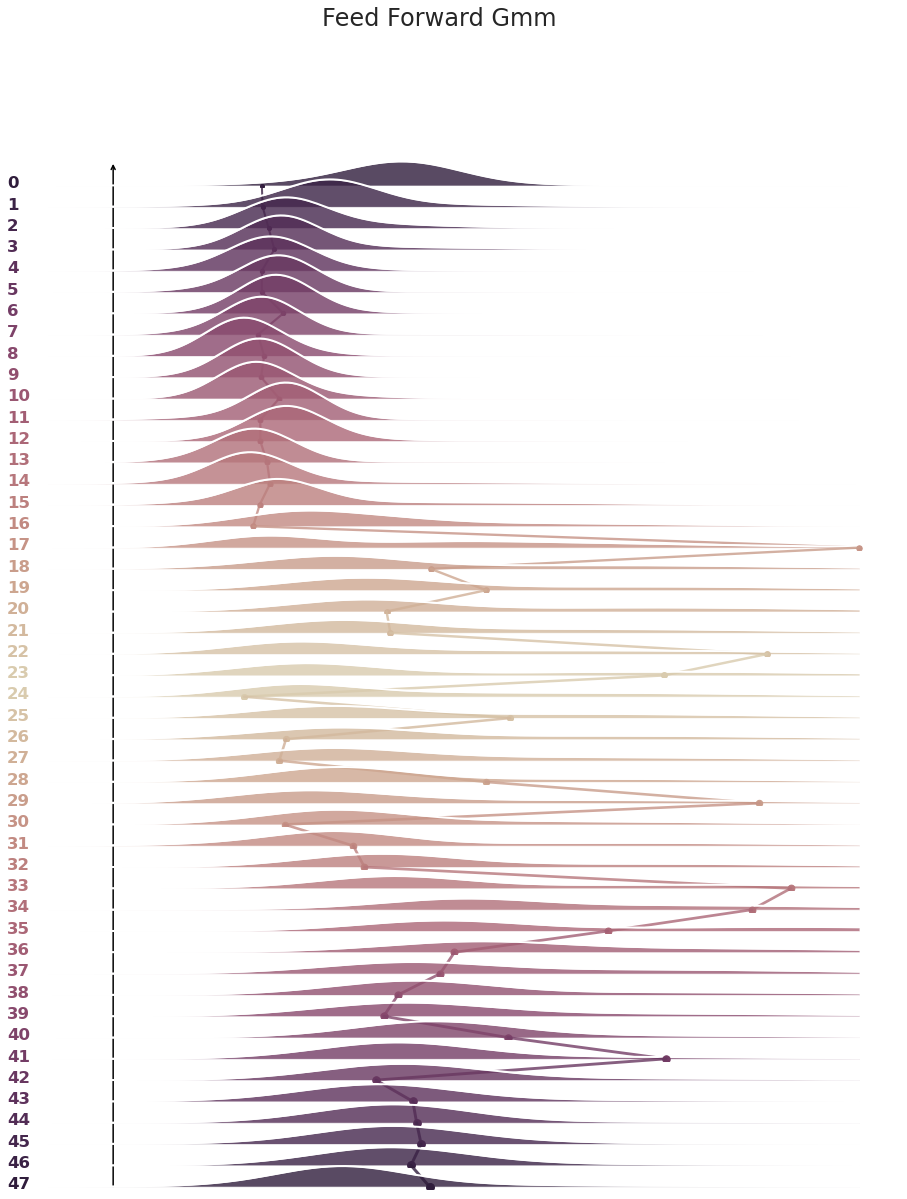

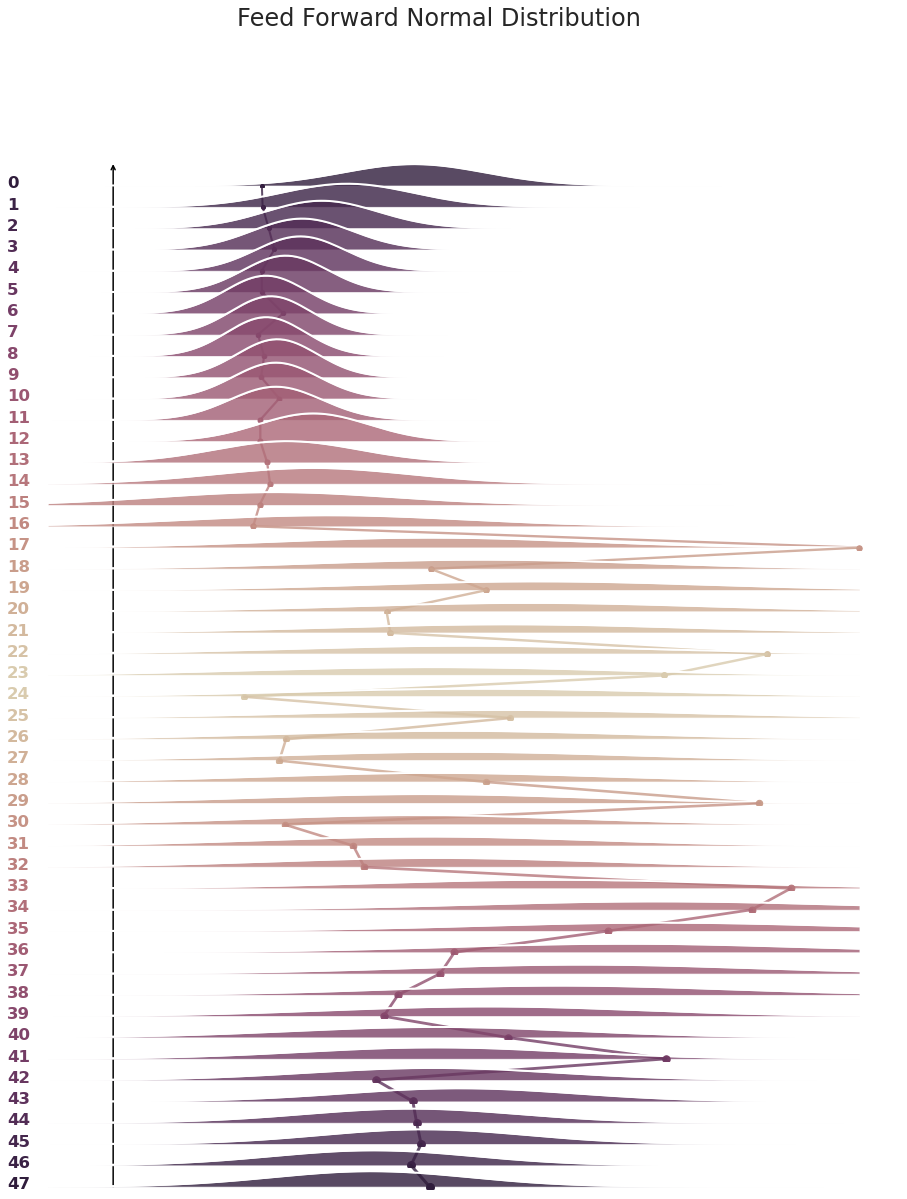

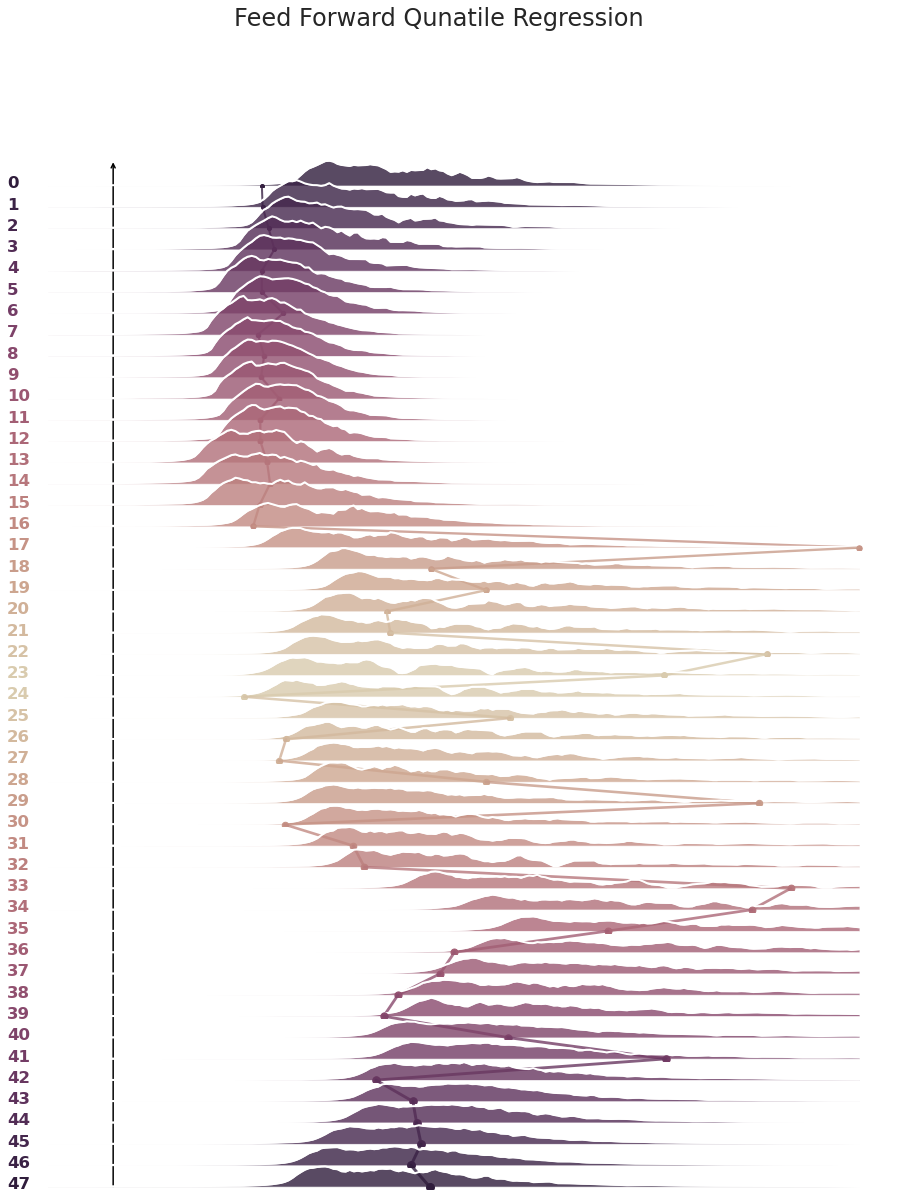

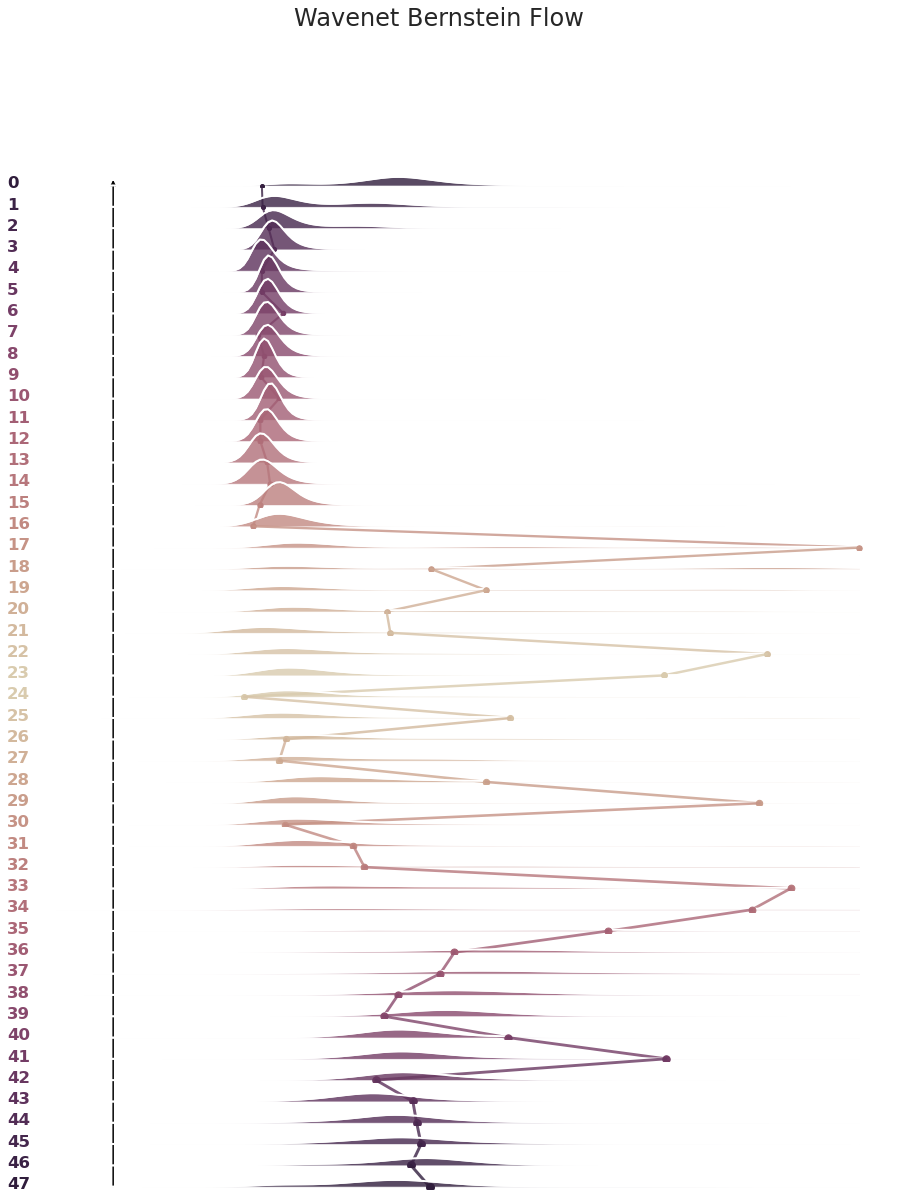

In [73]:
day=5
#flot_save_ridge_plots(eval_models,(test_x1[day],test_x2[day]),test_y[day],'_ridge_plot_week')
for m in [m for m in eval_models]:
    fig, ax = stacked_dist_plot(models[m], prob_models[m], (test_x1[:1],test_x2[:1]), test_y[:1])
    fig.suptitle(m.replace('_',' ').title(), fontsize=24)

# Sampleing from the learned distribution

In [ ]:
m='wavenet_bernstein_flow'
param_model=models[m]
prob_model=prob_models[m]

In [ ]:
x=(test_x1[:1],test_x2[:1])
y=test_y[:1]
dist=prob_model(param_model(x))

In [ ]:
n=500
samples=np.squeeze(dist.sample(n))
samples.min(),samples.max()

In [ ]:
samples = samples[(samples.max(axis=1) < 2*y.max()) & (samples.min(axis=1) >0)]
samples.shape[1]

In [ ]:
fig = plt.figure(figsize=(16,8))
fig=plt.plot(samples.T, color='gray', alpha=.1)
plt.plot(y[0])

# Evaluate on whole test data set

## NLL, MAE, MSE, CRPS, Pinball

In [74]:
metrics={}
for k,v in prob_models.items():
    metrics[k] = []
    metrics[k].append(MeanAbsoluteError(v, scale=14.134))
    metrics[k].append(MeanSquaredError(v, scale=14.134))
    metrics[k].append(ContinuousRankedProbabilityScore(v, scale=14.134))
metrics

{'feed_forward_bernstein_flow': [<bernstein_paper.metrics.mean_absolute_error.MeanAbsoluteError at 0x7ff3584318b0>,
 'feed_forward_gmm': [<bernstein_paper.metrics.mean_absolute_error.MeanAbsoluteError at 0x7ff3787e6e50>,
 'feed_forward_normal_distribution': [<bernstein_paper.metrics.mean_absolute_error.MeanAbsoluteError at 0x7ff3582a1310>,
 'feed_forward_qunatile_regression': [<bernstein_paper.metrics.mean_absolute_error.MeanAbsoluteError at 0x7ff35829c490>,
 'wavenet_bernstein_flow': [<bernstein_paper.metrics.mean_absolute_error.MeanAbsoluteError at 0x7ff358295610>,
  <bernstein_paper.metrics.continuous_ranked_probability_score.ContinuousRankedProbabilityScore at 0x7ff358243130>]}

In [75]:
eval_models

['feed_forward_bernstein_flow',
 'feed_forward_gmm',
 'feed_forward_normal_distribution',
 'feed_forward_qunatile_regression',
 'wavenet_bernstein_flow']

In [76]:
csv_files=sorted(file_list('.','csv'))
csv_files

[]

In [77]:
#try:
#    scores_df = pd.read_csv(csv_files[-1], index_col=[0])
#except FileNotFoundError as e:
#    print(e)

In [78]:
if 'scores_df' in globals():
    scores = {k.lower().replace(' ','_'): list(v.values()) for k,v in scores_df.to_dict('index').items()}
else:
    scores = {}
scores

{}

In [79]:
em = list(sorted(set(eval_models) - set(scores.keys())))
em

['feed_forward_bernstein_flow',
 'feed_forward_gmm',
 'feed_forward_normal_distribution',
 'feed_forward_qunatile_regression',
 'wavenet_bernstein_flow']

In [80]:
# em = [
    # 'feed_forward_bernstein_flow',
    # 'feed_forward_gmm',
    # 'feed_forward_normal_distribution',
    # 'feed_forward_qunatile_regression',
    # 'wavenet_bernstein_flow',
    # 'wavenet_gmm',
    # 'wavenet_normal_distribution',
    # 'wavenet_qunatile_regression'
# ]

In [ ]:
for m in em:
    compile_kwds=cfgs[m].compile_kwds
    compile_kwds['metrics'] = metrics[m]
    #compile_kwds['loss'] = NegativeLogarithmicLikelihood(prob_models[m])
    compile_kwds['run_eagerly'] = True if ('flow' in m) or ('qunatile_regression' in m) else False
    print(m,compile_kwds)
    models[m].compile(**compile_kwds)
    scores[m]=models[m].evaluate(ds)
scores

feed_forward_bernstein_flow {'loss': <bernstein_paper.losses.negative_logarithmic_likelihood.NegativeLogarithmicLikelihood object at 0x7ff3c0fb1070>, 'optimizer': 'adam', 'metrics': [<bernstein_paper.metrics.mean_absolute_error.MeanAbsoluteError object at 0x7ff3584318b0>, <bernstein_paper.metrics.mean_squared_error.MeanSquaredError object at 0x7ff3582cdf10>, <bernstein_paper.metrics.continuous_ranked_probability_score.ContinuousRankedProbabilityScore object at 0x7ff3582a8c40>], 'run_eagerly': True}
    882/Unknown - 4154s 5s/step - loss: -49.9319 - mean_absolute_error: 1.1577 - mean_squared_error: 184.1882 - continuous_ranked_probability_score: 0.0653

In [ ]:
#names = [cfgs[0].compile_kwds['loss'].name] + [m.name for m in cfgs[0].compile_kwds['metrics']]
index = [k.replace('_',' ').title() for k in scores.keys()]
columns = ['NLL','MAE','MSE','CRPS']
scores_df = pd.DataFrame(
    data=scores.values(),
    index=index,
    columns=columns
)

scores_df.sort_index()

In [ ]:
scores_df.combine_first(pd.read_csv(csv_files[-2], index_col=[0]))

In [ ]:
scores_df.to_csv(datetime.now().strftime("scores-%Y%m%d-%H%M%S.csv"))